## Complete Market Case
1 risky asset, 2 random outcomes

$$ V_D^{(0)}={1\over1+\gamma}\left[\pi(\omega_1)V_D^{(1)}+\pi(\omega_2)V_D^{(2)}\right] $$

이 때 replicating portfolio : $\theta=(\theta_0, \theta_1)$ 에 대해서

$$ V_D^{(0)}=\theta_0+\theta_1S^{(0)}\\ V_D^{(i)}=\theta_0(1+\gamma)+\theta_1S^{(i)} $$

$$ \therefore \theta_0={1\over1+\gamma}\frac{V_D^{(1)}S^{(2)}-V_D^{(2)}S^{(1)}}{S^{(2)}-S^{(1)}}\quad\quad\quad \theta_1=\frac{V_D^{(2)}-V_D^{(1)}}{S^{(2)}-S^{(1)}} $$


## Incomplete Market Case
1 risky asset, 3 or more random asset

### Super/Subhedging

- Superhedging
    \begin{aligned}
    P_{\text{sup}}&=\min_\theta{\langle\theta, S^{(0)}\rangle}=\sup_\pi\left[{1\over1+\gamma}\pi(\omega_i)V_D^{(i)}\right]
    \end{aligned}
- Subhedging
    \begin{aligned}
    P_{\text{sub}}&=\max_\theta{\langle\theta, S^{(0)}\rangle}=\inf_\pi\left[{1\over1+\gamma}\pi(\omega_i)V_D^{(i)}\right]
    \end{aligned}



# Derivative Pricing for Incomplete Market

## Maximizing Utility Price
- **constraint**
    $t=0$에서 derivative $D$에 대한 비용지불 $x$, fundamental asset의 portfolio $\theta$에 대해서 다음이 성립
    
    \begin{aligned}
    x + \theta_j S_j^{(0)}
    \end{aligned}

- Expected Utility
    \begin{aligned}
    L(V_D, x, \theta) = E[U] &= \sum_{i=0}^n\mu(\omega_i)\cdot U\left(V_D^{(i)}+\sum_{j=0}^m\theta_jS_j^{(i)}\right) \\
    &=\sum_{i=1}^n\mu(\omega_i)\cdot U\left(V_D^{(i)}-(1+\gamma)x+\sum_{j=1}^m\theta_j\left[S_j^{(i)}-(1+\gamma)S_j^{(0)}\right]\right)
    \end{aligned}

    \begin{aligned}
    (\because \theta_0S_0^{(0)}=-\left(x-\theta_jS_j^{(0)}\right))
    \end{aligned}

- Breakeven value (손익분기점)
    손익분기점이 되는 derivative의 spot price $x^* $ 는 다음을 만족
    $$ \max_\theta{L(V_D, x^*;\theta)}=\max_\theta{L(0,0;\theta)} $$

## Simulation
- 1 risky asset
- price at $t=1$ follows normal distribution $ S \sim \mathcal{N}(\mu, \sigma^2) $
    => more than 2 random outcomes
    => incomplete market
- Constant Absolute Risk Aversion Utility function
    $$ U(y)={1-e^{-ay}\over a} $$

따라서 investment in the risky asset $\alpha$, investment in the riskless asset $\beta$, risky asset price $S$, payoff of derivative $f(S)$ 에 대하여,

\begin{gather}
x+\beta + \alpha S_0 = 0 \quad\quad(\because S_0=1)\\
\max_\alpha E_S \left[{1-e^{-aL\left(f(S),x^*;\alpha\right)}\over a}\right] = 
\max_\alpha E_s \left[{1-e^{-aL\left(0,0;\alpha\right)}\over a}\right]
\end{gather}

where,

\begin{aligned}
&L\left(f(S),x^*;\alpha\right)=f(S)-(1+\gamma)x^*+\alpha(S-(1+\gamma)S_0) \\
&L\left(0,0;\alpha\right)=\alpha(S-(1+\gamma)S_0)\\
&\beta  = -\left(x+\alpha S_0\right)
\end{aligned}


`class MaxExpUtility`
- `risky_spot` : $S_0$
- `riskless_rate` : $\gamma$
- `risky_mean` : $\mu$
- `risky_stdev` : $\sigma$
- `payoff_func` : $f$

### Complete Market Price Method

$\alpha$는 investment기 때문에 holding $\theta$와 부호가 반대로, $ \theta_1 = -\alpha = {V^{(2)}-V^{(1)}\over S^{(2)}-S^{(1)}} $
$\beta$는 $V^{(i)} = \theta_0(1+\gamma) + \theta_1 S^{(i)}$ 로 부터, $\beta=-{V^{(i)}+\alpha S^{(i)}\over1+\gamma}$

### Max Expected Utility Value Method (0-payoff)

- total payoff
    $$ y=\beta S_0 + \alpha S = -(1+\gamma)c + \alpha(S-(1+\gamma)S_0)$$

따라서 최종 price는 expected utility를 최대화 하는 값으로 찾는다.

$$ \max_\alpha {E\left[U\left({1-\exp{-ay_\alpha(0, c)}\over a}\right)\right]} $$

이 때,
$$ \alpha^*={\mu-(1+\gamma)S_0 \over a\sigma^2} \\ \beta^* = -(c+\alpha^* S_0)$$

### Max Expected Utility Value Method
\begin{aligned}
\max_\alpha {E\left[U\left({1-e^{-ay(f(s), c)}\over a}\right)\right]}=\max_\alpha {E\left[U\left({1-e^{-ay(0, 0)}\over a}\right)\right]}
\end{aligned}

In [1]:
import time
def timer(fun):
    def wrapper(*args, **kwargs):
        start = time.time()
        res = fun(*args, **kwargs)
        eta = time.time() - start
        print(f'{fun.__name__} takes : {round(eta, 6)}s')
        return res
    return wrapper

In [2]:
import numpy as np

from dataclasses import dataclass
from typing import Callable
from scipy.stats import norm
from scipy.integrate import quad
from scipy.optimize import minimize_scalar, root_scalar

@dataclass(frozen=True)
class SimpleSimulation:
    risky_spot: float
    risky_mean: float
    risky_std: float
    riskless_rate: float
    payoff_fun: Callable[[float], float]

    def _total_return(self, c, alpha, payoff_fun=None):
        if payoff_fun is None:
            payoff_fun = self.payoff_fun

        riskless_coeff = 1 + self.riskless_rate
        return lambda s: payoff_fun(s) - \
                         riskless_coeff * c + alpha*(s - riskless_coeff*self.risky_spot)

    def _normal(self, x, mu, sigma):
        factor = 1/np.sqrt(2*np.pi)/sigma
        return factor * np.exp(-(x-mu)**2/(2*sigma**2))

    # @timer
    def complete_market_price(self):
        x1 = self.risky_mean - self.risky_std
        x2 = self.risky_mean + self.risky_std
        v1 = self.payoff_fun(x1)
        v2 = self.payoff_fun(x2)
        alpha = -(v2 - v1)/(x2 - x1)
        beta = -(v2+alpha*x2)/(1+self.riskless_rate)
        price = -(beta + alpha*self.risky_spot)

        return {'price': price, 'alpha': alpha, 'beta': beta}

    # @timer
    def max_expected_utility_zero(self, current_price, risky_aversion):
        riskless_coeff = 1 + self.riskless_rate
        mu, sigma, spot = self.risky_mean, self.risky_std, self.risky_spot
        alpha = (mu - riskless_coeff*spot)/(risky_aversion*sigma**2)
        beta = -(current_price+alpha*spot)
        max_val = (1-np.exp(
            -risky_aversion*(-riskless_coeff*current_price +
                             alpha*(mu - riskless_coeff*spot))
            + (risky_aversion * alpha* sigma)**2/2
        )) / risky_aversion
        return {'max_val': max_val, 'alpha': alpha, 'beta': beta}

    # @timer
    def max_expected_utility(self, current_price, risk_aversion, payoff_fun=None, num=0):
        if payoff_fun == 'zero':
            return self.max_expected_utility_zero(current_price, risk_aversion)
        if payoff_fun is None:
            payoff_fun = self.payoff_fun

        mu, sigma, spot = self.risky_mean, self.risky_std, self.risky_spot
        riskless_coeff = self.riskless_rate + 1

        lb = mu - sigma*6
        ub = mu + sigma*6
        norm_gap = norm.cdf(ub) - norm.cdf(lb)
        factor = 1/np.sqrt(2*np.pi)/sigma

        def expected_utility0(alpha):
            def integrand(s):
                payoff = self._total_return(current_price, alpha, payoff_fun)(s)
                utility = (1-np.exp(-risk_aversion*payoff))/risk_aversion
                return factor * np.exp(-(s-mu)**2/(2*sigma**2)) * utility
            return -quad(integrand, lb, ub)[0]

        def expected_utility1(alpha):
            def integrand(s):
                payoff = payoff_fun(s) - \
                         riskless_coeff * current_price + alpha * (s - riskless_coeff * spot)
                exponent = -(0.5 * (s - mu)**2 / (sigma**2)
                             + risk_aversion * payoff)
                return (1 - factor * np.exp(exponent)) / risk_aversion
            return -quad(integrand, lb, ub)[0]

        def expected_utility2(alpha):
            def integrand(s):
                payoff = self._total_return(current_price, alpha, payoff_fun)(s)
                exponent = -risk_aversion * payoff - (s-mu)**2/(2*sigma**2)
                return np.exp(exponent)
            return -(norm_gap - factor*quad(integrand, lb, ub)[0])/risk_aversion

        funs = [expected_utility0, expected_utility1, expected_utility2]
        res = minimize_scalar(funs[num])
        alpha = res['x']
        beta = - (current_price + alpha*spot)
        max_val = res['fun']

        return {'max_val': max_val, 'alpha': alpha, 'beta': beta}

    # @timer
    def max_expected_utility0(self, current_price, risk_aversion, payoff_fun=None):
        if payoff_fun == 'zero':
            return self.max_expected_utility_zero(current_price, risk_aversion)
        if payoff_fun is None:
            payoff_fun = self.payoff_fun

        mu, sigma, spot = self.risky_mean, self.risky_std, self.risky_spot
        riskless_coeff = self.riskless_rate + 1

        lb = mu - sigma*6
        ub = mu + sigma*6
        factor = 1/np.sqrt(2 * np.pi)/sigma
        norm_gap = norm.cdf(ub) - norm.cdf(lb)

        def expected_utility(alpha):
            def integrand(s):
                payoff = self.payoff_fun(s) - riskless_coeff*current_price + alpha*(s-riskless_coeff*spot)
                exponent = -(0.5 * (s - mu)**2/sigma**2 + risk_aversion*payoff)
                return factor * np.exp(exponent)
            return -(norm_gap - quad(integrand, lb, ub)[0])/risk_aversion

        res = minimize_scalar(expected_utility)
        alpha = res['x']
        beta = - (current_price + alpha*spot)
        max_val = res['fun']

        return {'max_val': max_val, 'alpha': alpha, 'beta': beta}

    # @timer
    def max_expected_utility_price(self, risky_aversion, num=0):
        zero_max_val = self.max_expected_utility_zero(0, risky_aversion)['max_val']
        max_val_eq = lambda x: self.max_expected_utility(x, risky_aversion, num=num)['max_val'] - zero_max_val

        lb = self.risky_mean - 10 * self.risky_std
        ub = self.risky_mean + 10 * self.risky_std
        # payoff_vals = self.payoff_fun(np.linspace(lb, ub, 1000))
        payoff_vals = [self.payoff_fun(x) for x in np.linspace(lb, ub, 1000)]
        a,b = min(payoff_vals), max(payoff_vals)

        optimal_price = root_scalar(max_val_eq, bracket=[a,b]).root
        hedges = self.max_expected_utility(optimal_price, risky_aversion)
        alpha = hedges['alpha']
        beta = hedges['beta']
        return {'price': optimal_price, 'alpha': alpha, 'beta': beta}


### Test

- initial risky price : $S_0$ = 100
- riskless rate : $5%$
- mean price of risky asset : $ 110$
- stdev of risky asset price : $ 25 $
- strick price : 105

In [3]:
sim = SimpleSimulation(risky_spot=100,
                       risky_mean=110,
                       risky_std=25,
                       riskless_rate=0.05,
                       # payoff_fun=lambda x: np.clip(x-105, 0, None))
                       payoff_fun=lambda x: max(x-105, 0))

### complete market case

- $\alpha = -0.6$
- $\beta = 48.57 $
- $ x = 11.43 $

call option에 대한 hedging으로 risky asset의 0.6 unit만큼을 공매도하고
그 수익 60$ 중 안전자산의 48.57 unit 만큼을 투자한다. (이 때 안전자산의 이자율 = 5%) 남은 자산으로 11.42$ 어치의 call option을 보유한다.

In [4]:
sim.complete_market_price()

{'price': 11.42857142857143, 'alpha': -0.6, 'beta': 48.57142857142857}

### incomplete market case

risk aversion $ a$가 커질수록 call option 가격, risky asset에 대한 investment가 줄어드는 것을 볼 수 있다.

In [5]:
for num in range(3):
    print(f'--- num: {num} ---')
    print(sim.max_expected_utility_price(0.3, num=num))

--- num: 0 ---
{'price': 5.233821338308665, 'alpha': -0.4733333333496044, 'beta': 42.09951199665178}
--- num: 1 ---
{'price': 23.279029745490945, 'alpha': -0.47333333333239613, 'beta': 24.05430358774867}
--- num: 2 ---
{'price': 5.233821345134001, 'alpha': -0.4733333333240041, 'beta': 42.09951198726641}


In [6]:
aversions = [.3, .6, .9]
for aversion in aversions:
    print(f'--- aversion: {aversion} ---')
    print(sim.max_expected_utility_price(aversion))

--- aversion: 0.3 ---
{'price': 5.233821338308665, 'alpha': -0.4733333333496044, 'beta': 42.09951199665178}
--- aversion: 0.6 ---
{'price': 3.6465897634422317, 'alpha': -0.4866666666801595, 'beta': 45.02007690457372}
--- aversion: 0.9 ---
{'price': 2.850283845033683, 'alpha': -0.4911111111429401, 'beta': 46.26082726926033}


#### Risky spot vs Call option price

In [4]:
import matplotlib.pyplot as plt

risky_spot = 100
risky_mean, risky_std = 110, 25
riskless_rate = 0.05
payoff_fun = lambda x: max(x-105, 0)

risk_aversion = 0.5

In [5]:
lb = risky_mean - risky_std*1.2
ub = risky_mean + risky_std*1.2

spots = np.linspace(lb, ub, 20)
markets = [SimpleSimulation(spot, risky_mean, risky_std, riskless_rate, payoff_fun) for spot in spots]
results = [market.max_expected_utility_price(risk_aversion, num=1) for market in markets]

KeyboardInterrupt: 

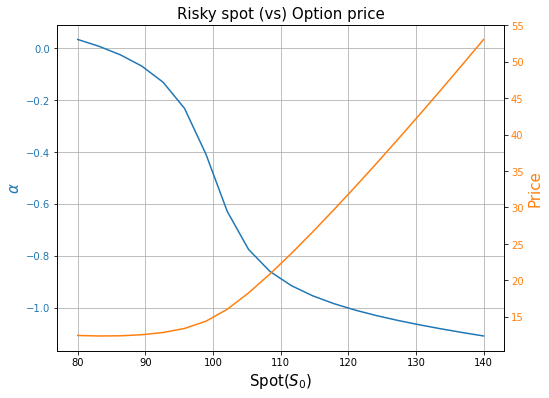

In [28]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(1,1,1)

ax.set_title('Risky spot (vs) Option price', size=15)
ax.grid(True)
ax.plot(spots, [res['alpha'] for res in results], label='alpha', color='C0')
ax.set_xlabel(r'Spot($S_0$)', size=15)
ax.set_ylabel(r'$\alpha$', color='C0', size=15)
ax.tick_params(axis='y', labelcolor='C0')

ax2 = ax.twinx()
ax2.plot(spots, [res['price'] for res in results], label='price', color='C1')
ax2.set_ylabel('Price', color='C1', size=15)
ax2.tick_params(axis='y', labelcolor='C1')


초기 risky asset의 value ($S_0$)가 높아지면 얻을 수 있는 수익이 작아지면서,
$\alpha$는 작아지고 (=> short-selling의 비율이 커지고) short-selling의 수익 증가로 인해 call option에 afford할 수 있는 금액이 커짐

#### Risky std vs Call option price

In [6]:
lb = risky_std - 20
ub = risky_std + 20

std_list = np.linspace(lb, ub, 20)
markets = [SimpleSimulation(risky_spot, risky_mean, std, riskless_rate, payoff_fun) for std in std_list]
results = [market.max_expected_utility_price(risk_aversion) for market in markets]

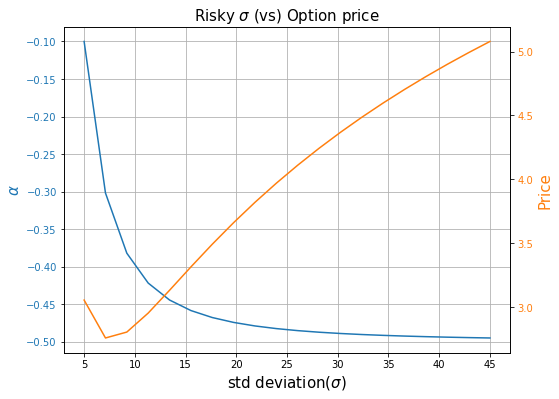

In [8]:
fig, ax = plt.subplots(figsize=(8,6))

ax.set_title(r'Risky $\sigma$ (vs) Option price', size=15)
ax.grid(True)
ax.plot(std_list, [res['alpha'] for res in results], label='alpha', color='C0')
ax.set_xlabel(r'std deviation($\sigma$)', size=15)
ax.set_ylabel(r'$\alpha$', color='C0', size=15)
ax.tick_params(axis='y', labelcolor='C0')

ax2 = ax.twinx()
ax2.plot(std_list, [res['price'] for res in results], label='price', color='C1')
ax2.set_ylabel('Price', color='C1', size=15)
ax2.tick_params(axis='y', labelcolor='C1')

risky asset의 변동성이 증가하면서 risky asset에 대한 short-selling 비율이 커지게 되었고, 그 수익금 증가로 인해 price도 상승
